In [25]:
import sys
sys.path.append('/home/nick/workspace/zoo-aquifer')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
import pymannkendall as mk
from sklearn import metrics
import seaborn as sns
from utils import viz

In [26]:
# Set notebook parameters
start_date = '1999-10-01'
end_date = '2023-09-30'

In [42]:
# Bring in data
df = pd.read_csv('../data/missoula_valley_wells_imputed_qreg.csv')
df_raw = pd.read_csv('../data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
df_static = pd.read_csv('../data/static_variables.csv')
df_norm = pd.read_csv('../data/dynamic_variables_all_normalized.csv', index_col=0, parse_dates=True)
df_norm = df_norm[(df_norm.index >= start_date) & (df_norm.index <= end_date)]
df_miller = pd.read_csv('../data/ross_miller_data.csv')
df_pop = pd.read_csv('../data/mso_pop_year.csv', index_col=0)

# Format streamflow data
q = df[['time', 'Q']]
q.set_index('time', inplace=True)
q.index = pd.to_datetime(q.index)
q_norm = df_norm['Q']

# Format groundwater data
df_norm['gw_avg'] = df_norm.iloc[:, 2:].mean(axis=1)
df_raw = -df_raw
depth_cols = [i for i in df.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df[col] *= -1

# Melt groundwater data
df_melt = df.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])
df_melt.rename(columns={'variable':'gwic_id'}, inplace=True)

## Introduction

The Missoula Aquifer is one of only 64 designated sole source aquifers in the United States.^[https://www.epa.gov/dwssa] As such, it supplies over 75,000 residents, plus businesses, with potable groundwater. Historically, the aquifer has shown incredible resilience to drought and increases in population within the Missoula valley area. There have been no long-term signs of depletion in any of the 27 monitoring wells within the aquifer. This is likely due to the very high transmissivity rates, location within the Clark Fork and Bitterroot watersheds, reasonable historical growth rates of the surrounding population, and only mild changes in historical climate. 

Due to the unconfined nature of the aquifer and the high transmissivity rates of the substrate, the upstream inflows, and downstream outflows, of the aquifer are largely driven by the Clark Fork River[@tallmanSourcesWaterCaptured2005; @millerNumericalFlowModel1991]. In fact, according to previous studies, the Clark Fork River provides over 80% of the annual aquifer recharge (@tbl-miller). Thus, it is fair to say that any long-term changes in streamflow will likely have far reaching impacts to the recharge and overall sustainability of the aquifer.     


In [30]:
#| label: tbl-miller
#| tbl-cap: Missoula aquifer source of average annual inflow according to 
#|   @millerNumericalFlowModel1991.

df_miller.style.hide()

Source,Inflow (acre-ft)
Clark Fork River,192000
Creek Drainages and Tertiary Hillsides,19000
Lateral Underflow (Bitterroot and Hellgate),21000
Total,232000



Climate change is expected to impact the Clark Fork River in numerous ways over the coming decades [@whitlock2017MontanaClimate2017]. Average annual discharge is projected to increase, although there is large uncertainty around this projection. With higher confidence, there is expected to be a shift in the timing of peak runoff leading towards lower baseflows in the summer months. In addition, when future drought occurs, the severity is expected to increase, resulting in extended periods of drier than normal conditions [@montanadnrcMontanaDroughtManagement2023]. These projected changes will undoubtedly affect the groundwater of the Missoula Aquifer and the impact of the local extractions for drinking water, irrigation, and industrial purposes.  

From 2000 to 2024 the Missoula area population has increased from 57,000 to 78,000, respectively.^[https://www.census.gov/programs-surveys/popest.html] Using the standard assumption of 160 gallons/day/person, we estimate that water use has increased from 10,200 af to 14,100 af over this same time period (@fig-water-use). Consequently, according to the Montana Ground Water Information Center^[https://mbmggwic.mtech.edu] there are currently over 3,500 wells listed in the Missoula area. Of those wells, 247 are labeled as "public water" which includes the City of Missoula's water supply (@fig-extract-map). Population in the Missoula area is expected to continue to increase over the next several decades^[Correspondence with Marc Hendrickson on 2/13/2024] likely leading to more wells and higher extraction rates to sustain this growth. In spite of the historical resilience of the aquifer to these changes, many questions still remain unanswered.  

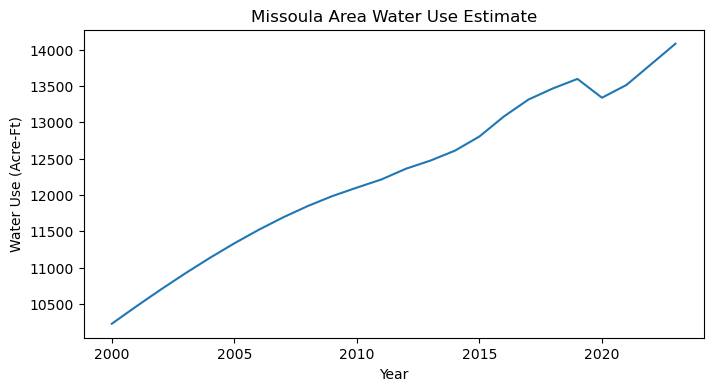

In [65]:
#| label: fig-water-use
#| fig-cap: Estimated water use based on the U.S. Census population data within the Missoula area
#|  and an average consumption of 160 gallons/day/person.

df_pop['WatUse_af'].plot(figsize=(8, 4))
plt.xlabel('Year')
plt.ylabel('Water Use (Acre-Ft)')
plt.title('Estimated Missoula Area Water Use')
plt.show()

![All extraction points within the Missoula area.](./images/missoula_valley_all_extractions.jpeg){#fig-extract-map}

What if climate change and population growth converge to maximize stress on the aquifer? While these kinds of scenarios are not determined, they are all well within the realm of realistic possibilities, perhaps even probable. Given the overall resilience that we have seen in the past, it is possible that the aquifer can withstand these stressors and continue to deliver clean and plentiful potable water to the Missoula community in perpetuity. However, to date, no one has studied these different scenarios to make sure that our future water resources are protected. In this analysis, we first evaluate the long-term historial trends in Clark Fork River discharge, City of Missoula pumping rates, and Missoula Aquifer water table depth. In subsequent analyses (not inlcuded in this preliminary report) we plan to specifically study the impacts of plausible future scenarios on the Aquifer to identify critical tipping points and mitigation strategies.  

## Methods

### Study Area

The study area includes the greater Missoula area. Within this region there are 16 monitoring wells used in the analysis @fig-site-map. 

![The study site including the 16 monitoring wells used in the analysis.](./images/site_map.png){#fig-site-map}

### Data Imputation

Historical groundwater measurements from the 16 sites were taken sporadically and inconsistently (@fig-gw-imputation). Therefore, in order to compare across all sites we needed to fill the data gaps and resample to monthly average values. We gap-filled the data using a mulitple linear regression imputation method based on the Clark Fork River monthly average flow and the day of the year (i.e. last day of the month) to create consistent monthly data across all water years (2000-2023) in each monitoring well used in the study. We tested several other methods including linear interpolation, time-based interpolation, and seasonal trend decomposition using LOESS (STL) by iterating the method 100 times and leaving out 5 known data points to later predict with the model. The multiple linear regression data imputation method proved to have the best error statistics across the all metrics (MAE, MSE, RMSE, MAPE, and R-squared). 

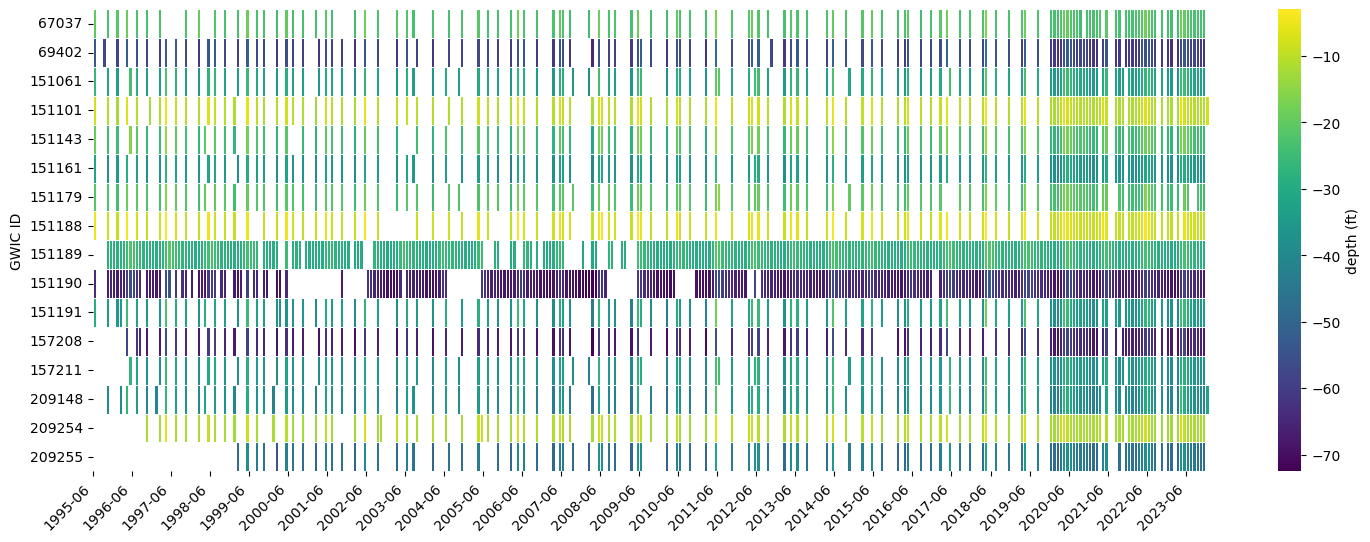

In [19]:
#| label: fig-gw-imputation
#| fig-cap: The groundwater data points for each well before imputation. Color
#|  represents the value of the measurement (i.e. depth below ground). 

fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_ylabel('GWIC ID')
ax.set_xlabel('')
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

## Historical Analysis

### Clark Fork River

The Clark Fork River serves as the main source for aquifer recharge in the Missoula Valley [@tallmanSourcesWaterCaptured2005]. While other inputs exist, we focus almost exclusively on the Clark Fork due to the overall magnitude relative to other inputs, and the high temporal correlation with one another that all the inputs exhibit [CITE Johnnie analysis]. A seasonal decomposition using LOESS (@fig-cfr-stl) shows that there has been a consistent increasing trend in monthly average flows over the study period (2000-2023). In addition, as expected, there is a strong seasonality component with peak flows coming in late spring and baseflows in late summer and early fall. 

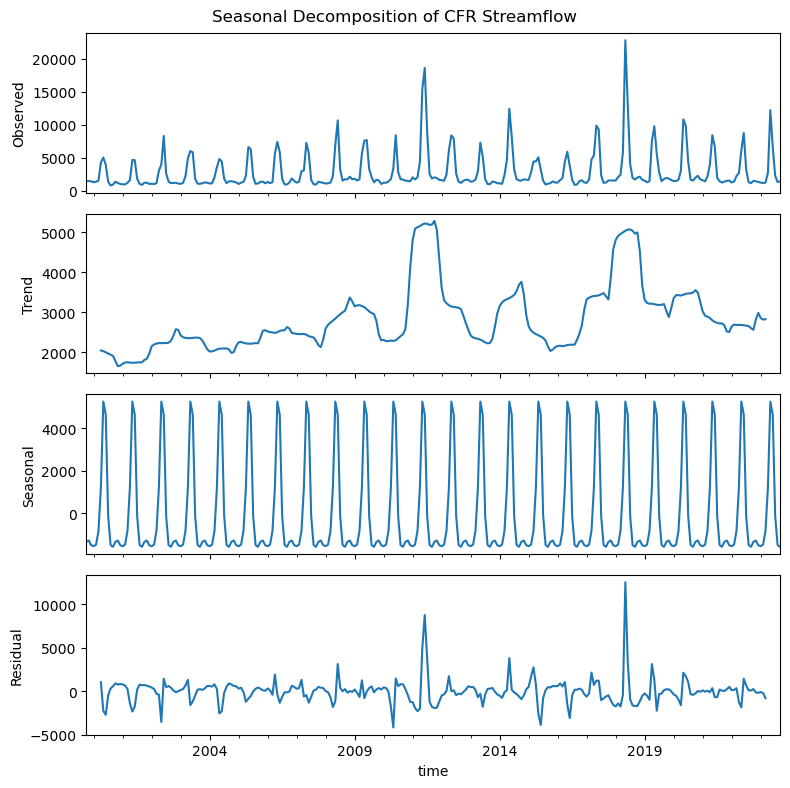

In [20]:
#| label: fig-cfr-stl
#| fig-cap: 
#|  Seasonal decomposition of the Clark Fork River monthly streamflows. The top 
#|  figure is the full stremflow signal, the second from the top shows the trend 
#|  over the time, the third from the top figure is the seasonal signal, and the 
#|  bottom figure is the residual after the trend and seasonal components have been 
#|  removed.

# stl_q = STL(q, seasonal=13, period=12, robust=True, trend=39)
# res_q = stl_q.fit()
res_q = seasonal_decompose(q, period=12)
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res_q.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
res_q.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
res_q.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
res_q.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of CFR Streamflow')
fig.subplots_adjust(top=0.95)
plt.show()



We investigate the trend further using a Mann-Kendall test (@mannNonparametricTestsTrend1945, @kendallRankCorrelationMethods1975), which avoids assumptions of normality and independence. The results indicate a statistically significant ($p<0.5$) increasing trend of 24 cfs/month. We further break down the trend analysis into seasons: winter (December, January, February), spring (March, April, May), summer (June, July, August), and fall (September, October, November) (@fig-cfr-seas-trends). All four seasons have increasing trends, although the summer season's trend is not statistically significant at the $p<0.5$ level. 

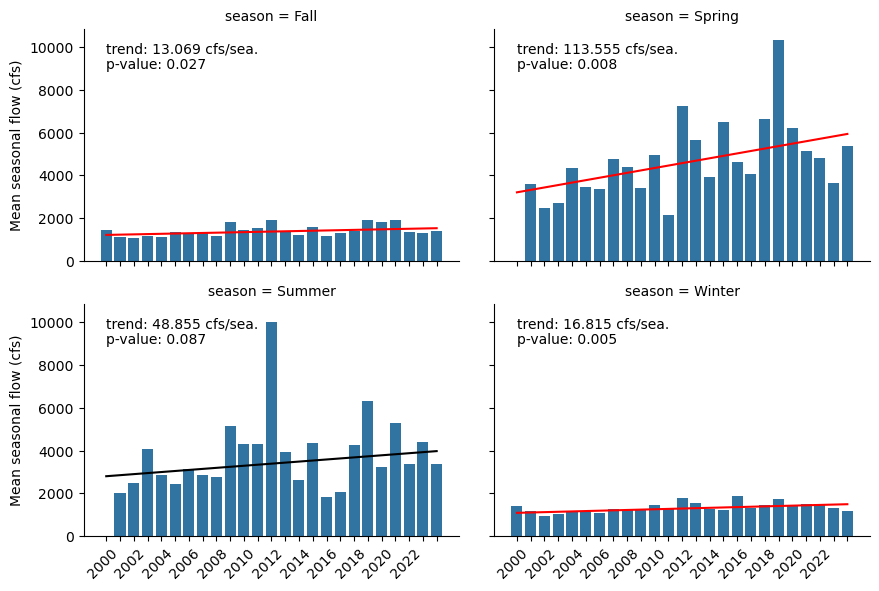

In [21]:
#| label: fig-cfr-seas-trends
#| fig-cap: Seasonal trends for Clark Fork River flows. Red line indicates a 
#|  statistically significant ($p<0.05$) trend. 

# Create the FacetGrid plot
q = q.assign(season = q.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}))

q_seas = q.groupby('season').resample('Y')['Q'].mean().reset_index(['season'])
q_seas.index = q_seas.index.strftime('%Y')
g = sns.FacetGrid(q_seas.reset_index(), col='season', col_wrap=2, sharey=True, sharex=True, height=3, aspect=1.5)
g.map(sns.barplot, 'time','Q', order=q_seas.index.unique())
g.set_ylabels('Mean seasonal flow (cfs)')

# Look for trends in seasons
mk_seas_w = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Winter').dropna())
mk_seas_sp = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Spring').dropna())
mk_seas_su = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Summer').dropna())
mk_seas_f = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Fall').dropna())

pvals = [mk_seas_f.p, mk_seas_sp.p, mk_seas_su.p, mk_seas_w.p]
ms = [mk_seas_f.slope, mk_seas_sp.slope, mk_seas_su.slope, mk_seas_w.slope]
x1 = 0
x2 = 24 
pts1 = [[x1, x2], 
        [x1, x2], 
        [x1, x2], 
        [x1, x2]] 

pts2 = [[mk_seas_f.slope*x1 + mk_seas_f.intercept, mk_seas_f.slope*x2 + mk_seas_f.intercept], 
        [mk_seas_sp.slope*x1 + mk_seas_sp.intercept, mk_seas_sp.slope*x2 + mk_seas_sp.intercept], 
        [mk_seas_su.slope*x1 + mk_seas_su.intercept, mk_seas_su.slope*x2 + mk_seas_su.intercept], 
        [mk_seas_w.slope*x1 + mk_seas_w.intercept, mk_seas_w.slope*x2 + mk_seas_w.intercept]] 

# Rotate the x-tick labels, add text, and trendlines on all subplots
for i, ax in enumerate(g.axes.flat):
    m = f"trend: {ms[i]:.3f} cfs/sea."
    pval = f"p-value: {pvals[i]:.3f}"
    if pvals[i] > 0.05:
        c = 'black'
    elif pvals[i] <= 0.05:
        c = 'red'
    ax.text(0, 9000, pval)
    ax.text(0, 9700, m)
    ax.plot(pts1[i], pts2[i], color=c)
    # ax.text(1, 8000, str(i))
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

plt.show()

### Groundwater Table Depth

We evaluated trends in groundwater table depth for each of the 16 wells within the study site using the Mann-Kendall test. All 16 wells have significantly increasing trends and strong seasonality similar to the Clark Fork River streamflow (@fig-gw-trends). 

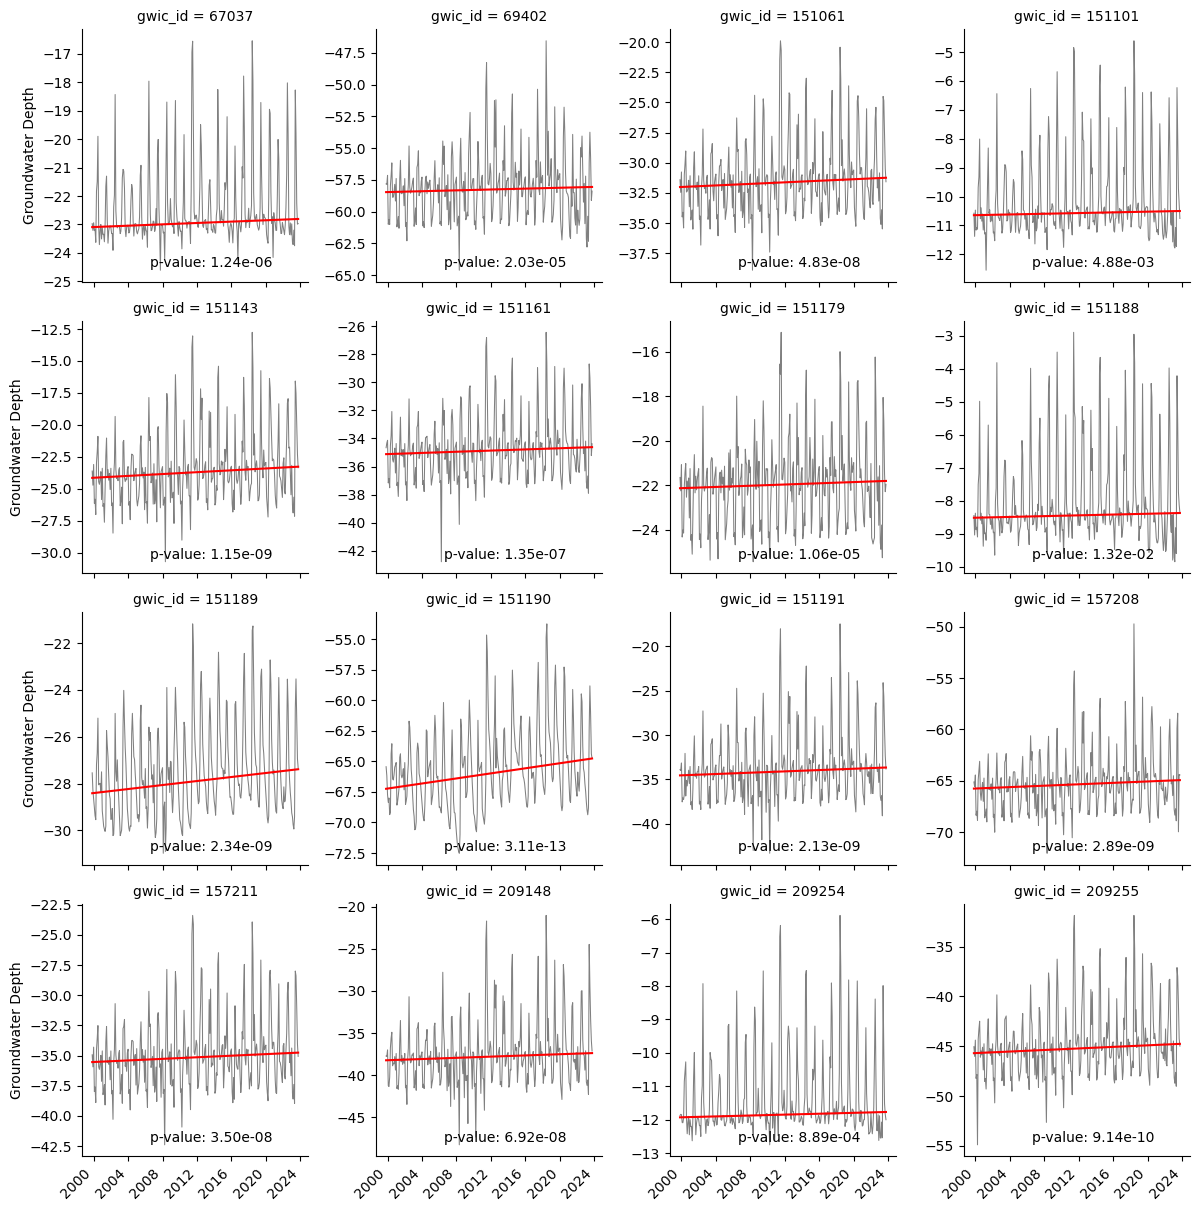

In [22]:
#| label: fig-gw-trends
#| fig-cap: Trends in groundwater depth for the 16 wells within the study area. Red
#|  line indicates a statistically significant trend ($p<0.05$). 

# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)
g.set_ylabels('Groundwater Depth')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

Additionally, we calculated the 10th, 50th, and 90th quantile regression lines to show trends in lower, median, and upper values, respectively (@fig-gw-quantreg). The results show strong increasing trends in the upper quantile of each well, suggesting that increases in peak recharge events are largely driving the overall trend in the groundwater. Median and lower quantiles show less of an increasing trend and sometimes even decreasing trends. The decreasing trends in the lower quantiles tend to located in the south and west regions the study site (@fig-gw-quantreg-lower). The difference in trends between the 90th and 10th percentile also suggest an overall increase in interannual variability throughout the time period. 

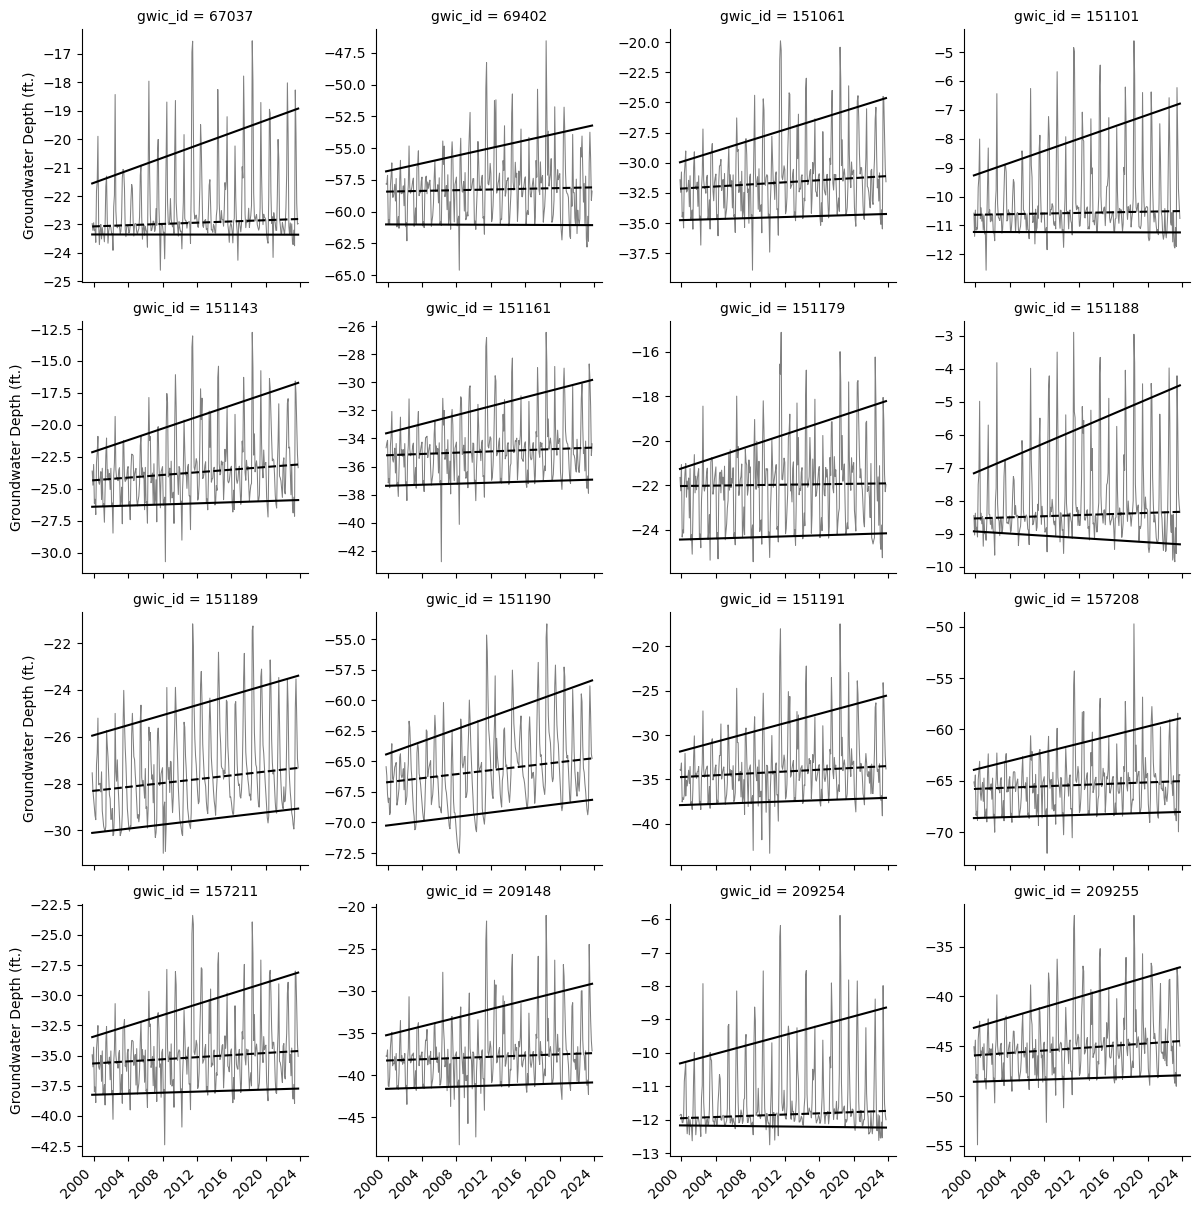

In [23]:
#| label: fig-gw-quantreg
#| fig-cap: Upper (90th percentile), median (50th percentile, dashed), and lower 
#|  (10th percentile) trends in groundwater data. The 90th percentile trends
#|  are consistently the largest, suggesting increases in peak recharge events 
#|  and interannual variability.

# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_quantreg)
g.set_ylabels('Groundwater Depth (ft.)')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

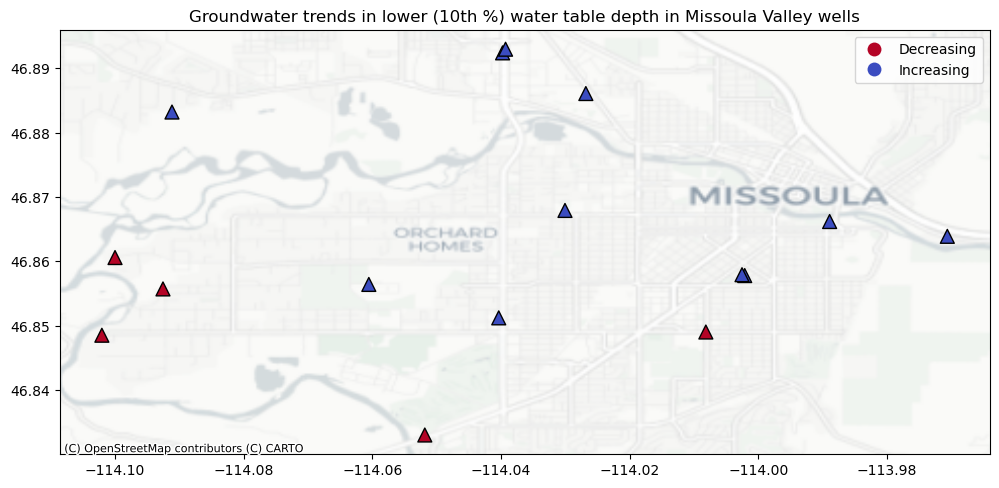

In [24]:
#| label: fig-gw-quantreg-lower
#| fig-cap: Trends in lower (10th percentile) groundwater depths. The red markers indicate 
#|  decreasing trends. The blue markers indicate increasing trends. 

# Calculate slope of quantile regression lines
gwicids = df_trend['gwic_id'].unique()
df_quantreg = pd.DataFrame(columns=['gwicid', 'quantreg_m1', 'quantreg_m9', 'quantreg_m5'])
for gwicid in gwicids:
    data = df_trend[df_trend['gwic_id'] == gwicid]
    q1, q9, q5 = viz.plot_data_and_quantreg(data, 'blue', quants=[0.1, 0.9], plot=False)
    m1, m9, m5 = q1.params.x, q9.params.x, q5.params.x
    new_data = [gwicid, m1, m9, m5]
    df_quantreg.loc[len(df_quantreg)] = new_data

# Add trends to spatial dataframe
trends.index = trends.index.astype('int64')
df_stat = df_static.merge(trends, left_on='gwicid', right_index=True)
df_stat['gwicid'] = df_stat['gwicid'].astype(str)
df_stat = df_stat.merge(df_quantreg, left_on='gwicid', right_on='gwicid') 

# Convert to GeoDataFrame
df_stat['geometry'] = [Point(xy) for xy in zip(df_stat.longitude, df_stat.latitude)]
gdf_stat = gpd.GeoDataFrame(df_stat, geometry='geometry', crs='EPSG:4326')

# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='quantreg_m1', 
                   cmap='coolwarm_r', 
                   legend=True, 
                   edgecolor='black',
                   marker='^',
                   scheme='User_Defined',
                   classification_kwds=dict(bins=[0]),
                   s=100)

# Change legend text
leg_text = ['Decreasing', 'Increasing']
leg = ax.get_legend()
for i, l in enumerate(leg.get_texts()):
    l.set_text(leg_text[i])

ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
# cbar = ax.get_figure().get_axes()[1]
# cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater trends in lower (10th %) water table depth in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

### Groundwater Withdrawals 

To understand the relationship and timing of groundwater levels, Clark Fork streamflow, and Missoula City pumping rates, we normalize all monthly values to be between zero and one (@fig-norm-ts). We average the normalized groundwater depths across all wells to get one groundwater signal to compare to river flows and pumping rates. The signals are remarkably aligned in their seasonality. Of course, groundwater is a dependent variable, but river flows and pumping rate are independent. Essentially, the City is increasing their pumping at the same time streamflow, and thus groundwater, are at their maximum. This is an opportunitistic situation and one that should be monitored closely if streamflow timing were to shift due to changes in snowpack runoff, as projected by climate change studies [@whitlock2017MontanaClimate2017]. The main difference in these three signals is the lagged decrease in groundwater levels in comparison to the river and pumping rate. Groundwater tends to drop much slower than the two independent variables, suggesting there is some storage effect in the unconfined aquifer. 

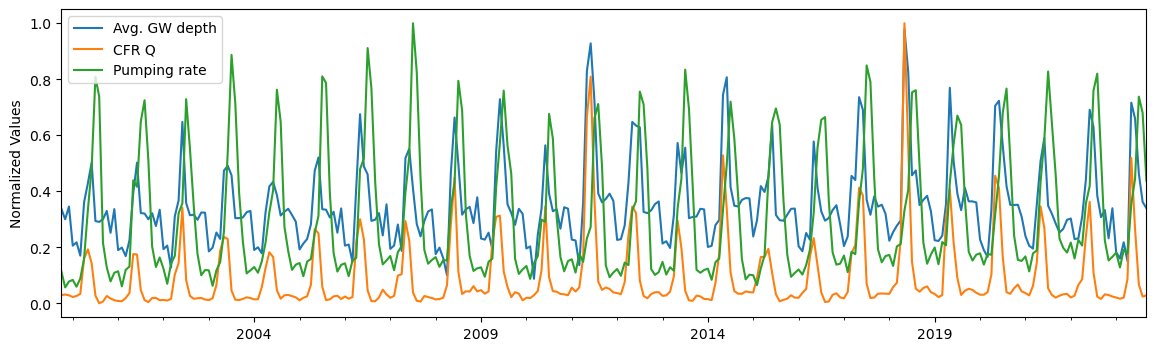

In [25]:
#| label: fig-norm-ts
#| fig-cap: Normalized timeseries values for average groundwater depth (blue),
#|  Clark Fork River streamflow (orange), and Missoula City pumping rates
#|  (green). All values are monthly averages. 

# Plot normalized time seris of gw, q, and pumping rate   
plt.figure(figsize=(14, 4))
df_norm['gw_avg'].plot(label='Avg. GW depth')
df_norm['Q'].plot(label='CFR Q')
df_norm['pumping_rate'].plot(label='Pumping rate')
plt.ylabel('Normalized Values')
plt.legend()
plt.show()

Similar to the Clark Fork river flows and groundwater level, the City pumping rate also has an overall increasing trend and strong seasonality over the study time period (@fig-pumping-stl). While the overall trend is increasing, there are three smaller trends that are distinct across the time period. From 2000 to 2007 the pumping rate increases, then from 2007 to 2015 the pumping rate decreases, followed by another strong increasing trend from 2015 to 2023. 

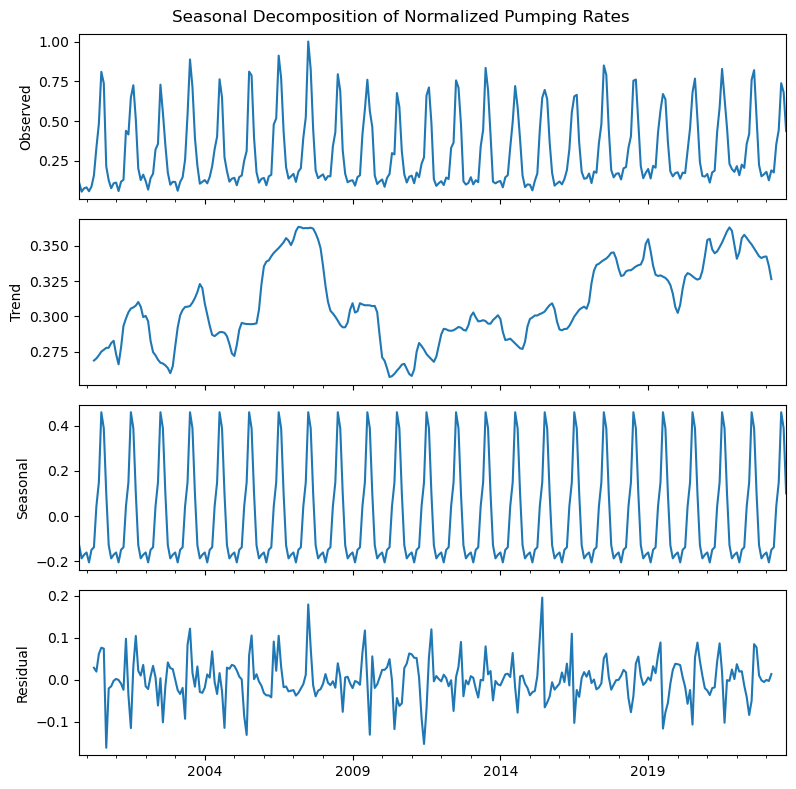

In [26]:
#| label: fig-pumping-stl
#| fig-cap: The seasonal decomposition using LOESS of the City of Missoula
#|  pumping rates. The top figure is the combined signal, the second to the
#|  top is the trend, the third from the top is the seasonality, and the 
#|  bottom figure is the residual after trend and seasonality are removed.

# res_pr = STL(df_norm['pumping_rate'], seasonal=13, period=12, trend=39, robust=True).fit()
res_pr = seasonal_decompose(df_norm['pumping_rate'], period=12)
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res_pr.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
res_pr.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
res_pr.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
res_pr.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of Normalized Pumping Rates')
fig.subplots_adjust(top=0.95)
plt.show()

The most recent 10 water-years (2014-2023) provide an interesting case study. Over this time period, pumping rates have strongly increased and river flows have remained around the same (slight increase), yet the groundwater trends from the majority of the wells have either decreased or are no longer statistically significant (@fig-gw-recent). This suggests that there are other factors influencing groundwater levels, most likely groundwater withdrawals.  

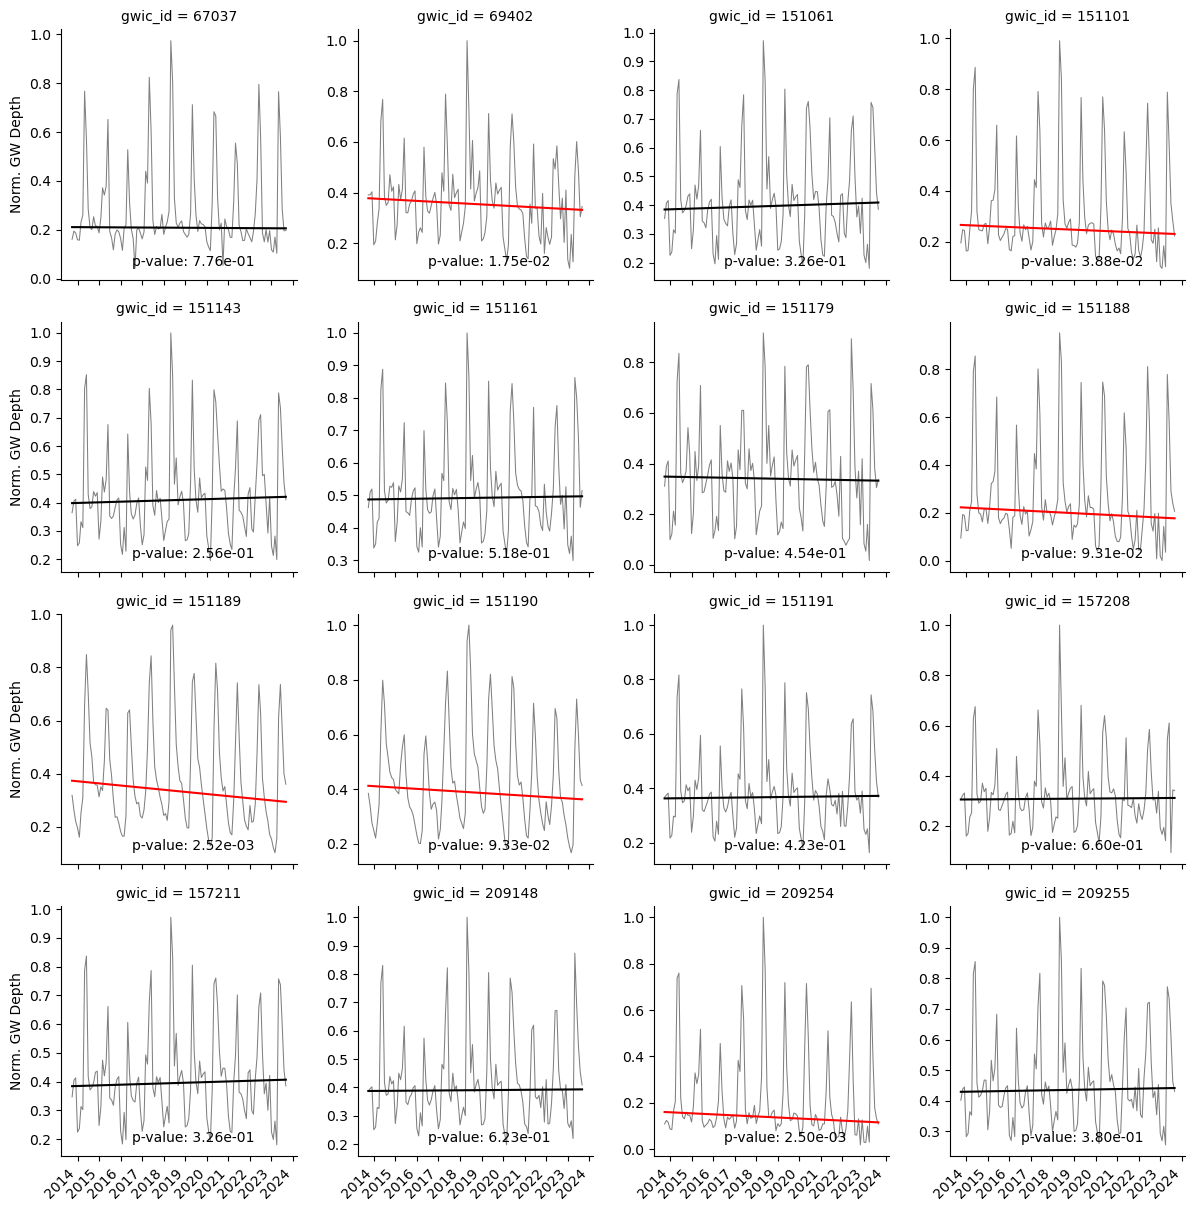

In [30]:
#| label: fig-gw-recent
#| fig-cap: The most recent 10-years of groundwater level data with trends
#|  (significant and non-significant).

rec_mask = (df_norm.index >= '2013-10-01')
df_rec = df_norm.loc[rec_mask]
df_rec = df_rec.drop(columns=['Q', 'pumping_rate', 'gw_avg'])
df_rec_melt = df_rec.reset_index().melt(id_vars='index')
df_rec_melt['time'] = pd.to_datetime(df_rec_melt['index'])
df_rec_melt.drop(columns=['index'], inplace=True)
df_rec_melt.rename(columns={'variable':'gwic_id'}, inplace=True)

# Melt dataframe
df_rec_trend = df_rec_melt.copy()
df_rec_trend['timestamp'] = df_rec_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
rec_trends = df_rec_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_rec_trend = df_rec_trend.join(rec_trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_rec_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

g.set_ylabels('Norm. GW Depth')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()


In order to understand how withdrawals may be impacting groundwater levels over the entire time period, we remove the normalized trend in river flow from the groundwater signal at all wells (@fig-gw-qremoved). Once the river flow trend is removed, changes in groundwater depth are shifted from increasing to decreasing in 14 of the 16 wells. This suggests that if the river flows were not increasing over this time period, groundwater trends would likely be decreasing. Thus, the river is masking the decreasing trends in groundwater and given that there is no evidence for an increasing trend in river flow to continue into the future, it is important to consider what can be done now to minimize these underlying changes in groundwater level. 

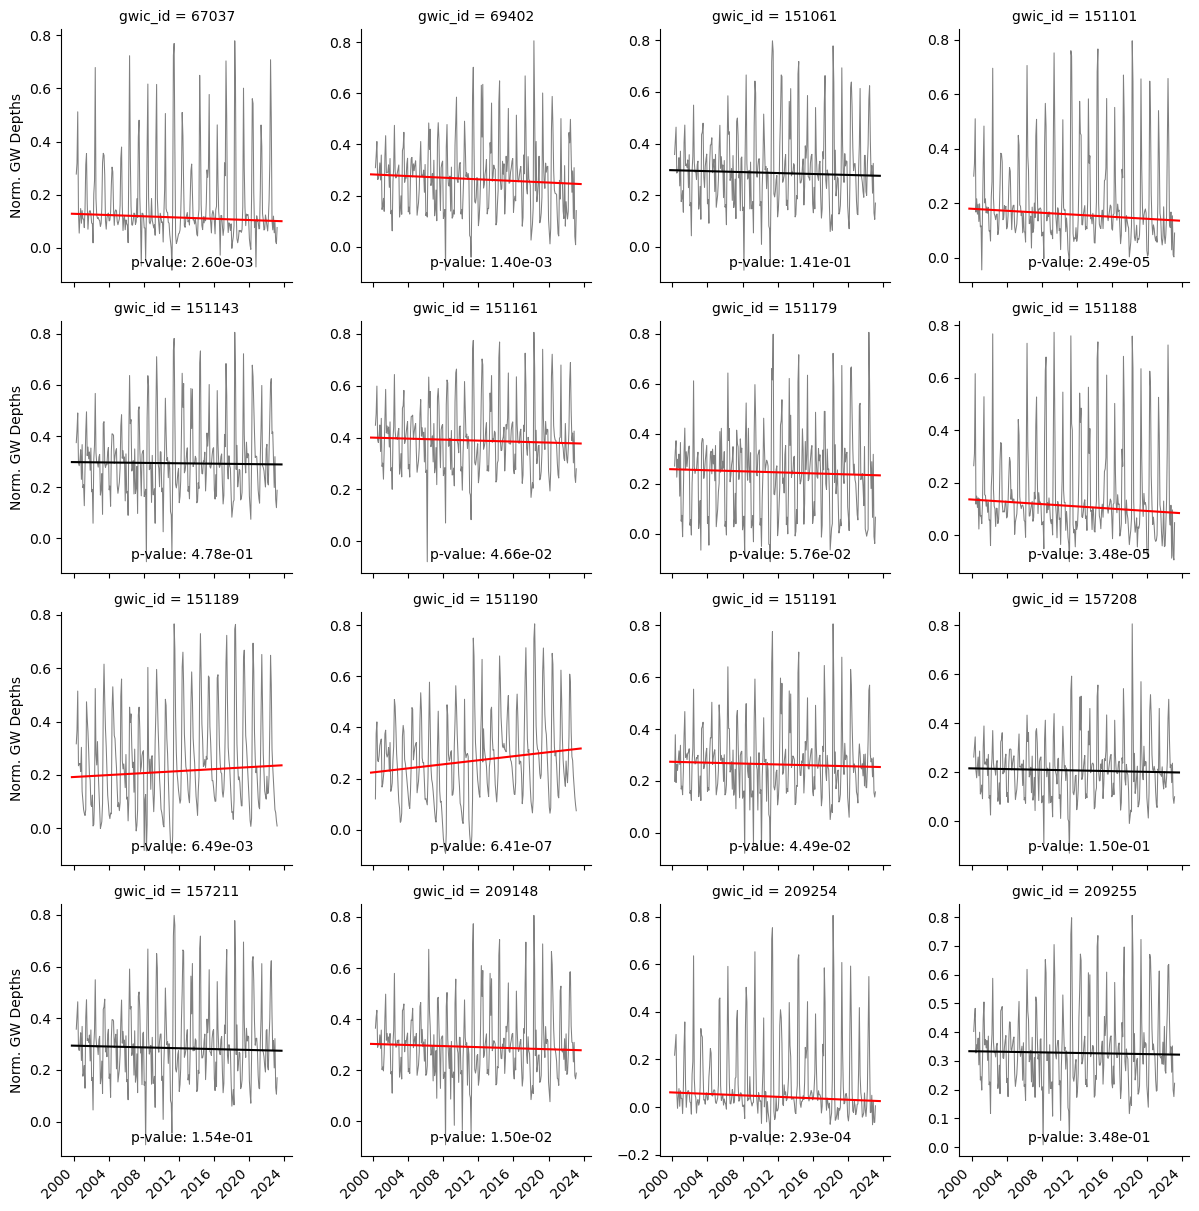

In [31]:
#| label: fig-gw-qremoved
#| fig-cap: Trends in groundwater depth after the normalized Clark Fork River
#|  has been removed. 

# Seasonally decompose and melt
# res_q_norm = STL(q_norm, seasonal=13, period=12, robust=True, trend=39).fit()
res_q_norm = seasonal_decompose(q_norm, period=12)
df_corr = df_norm.drop(columns=['Q', 'pumping_rate', 'gw_avg'])
df_corr = df_corr.sub(res_q_norm.trend, axis=0)

df_corr_melt = df_corr.reset_index().melt(id_vars='index')
df_corr_melt['time'] = pd.to_datetime(df_corr_melt['index'])
df_corr_melt.drop(columns=['index'], inplace=True)
df_corr_melt.rename(columns={'variable': 'gwic_id'}, inplace=True)
df_corr_trend = df_corr_melt.copy()
df_corr_trend['timestamp'] = df_corr_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
corr_trends = df_corr_trend.groupby('gwic_id').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_corr_trend = df_corr_trend.join(corr_trends, on='gwic_id')

# Create the FacetGrid plot
g = sns.FacetGrid(df_corr_trend, col='gwic_id', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

g.set_ylabels('Norm. GW Depths')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

## Summary

All of the trends calculated in this analysis are summarized in @tbl-slopes. The original trends are all strongly increasing, trends in the lower percentile are mixed, trends in the 90th percentile are all increasing strongly, trends in the most recent 10 years are mostly decreasing, and trends when the Clark Fork River trend is removed are almost entirely decreasing. 

In [33]:
#| label: tbl-slopes
#| tbl-cap: 'All groundwater trends color mapped with cool colors representing increasing
#|  trends and warm colors representing decreasing trends. The rows are GWIC IDs and the
#|  columns are as follows: Trend (raw data), 10th % (Lower percentile), 90th % (upper
#|  percentile), Median (50th percentile), Recent (most recent 10 years), and Q removed
#|  (trend after the river flow trend was removed).' 

m = trends.slope
m.index = m.index.astype(str)
m.name = 'Trend'
m_corr = corr_trends.slope
m_corr.name = 'Q removed'
m_rec = rec_trends.slope
m_rec.name = 'Recent'
m_qr = df_quantreg.set_index('gwicid')
m_qr.rename(columns={
    'quantreg_m1': '10th %',
    'quantreg_m5': 'Median',
    'quantreg_m9': '90th %'
    }, inplace=True)
df_m = pd.concat([m.to_frame(), m_qr, m_rec, m_corr], axis=1)
df_m.style.background_gradient('coolwarm_r',
                               vmin=-0.01,
                               vmax=0.01,
                               axis=None)

,Trend,10th %,90th %,Median,Recent,Q removed
151061,0.032163,0.001779,0.018536,0.003612,0.002448,-0.000914
151101,0.006044,-0.000054,0.008658,0.000451,-0.003573,-0.001840
151143,0.036425,0.001829,0.018914,0.004328,0.002246,-0.000388
151161,0.020813,0.001529,0.013252,0.001901,0.000978,-0.000955
151179,0.013695,0.000977,0.010625,0.000415,-0.001614,-0.001035
151188,0.006000,-0.001371,0.009278,0.000702,-0.004630,-0.002174
151189,0.042835,0.003613,0.008919,0.003431,-0.008008,0.001848
151190,0.103543,0.007349,0.021091,0.006837,-0.004975,0.003941
151191,0.037104,0.002852,0.021894,0.004329,0.000939,-0.000853
157208,0.034414,0.002080,0.017454,0.002634,0.000621,-0.000707


## References

::: {#refs}
:::